In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import cv2
from PIL import Image

%matplotlib inline

print('Using Tensorflow', tf.__version__)

Using Tensorflow 2.3.0


In [ ]:
PATH='/content/drive/My Drive/Face Mask Detection Model'

training_data=np.load('/content/drive/My Drive/Face Mask Detection Model/Train/training_data.npy', allow_pickle=True)
testing_data=np.load('/content/drive/My Drive/Face Mask Detection Model/Test/testing_data.npy', allow_pickle=True)

In [ ]:
print(len(training_data))
print(len(testing_data))

3200
633


In [ ]:
IMG_SIZE=128

def load_data():
  X_train=np.array([x[0] for x in training_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
  Y_train=np.array([y[1] for y in training_data])

  X_test=np.array([x[0] for x in testing_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
  Y_test=np.array([y[1] for y in testing_data])

  return (X_train,Y_train),(X_test,Y_test)

In [ ]:
class_names=['without mask','with mask']

def show_some_samples(x,y,p):
    indices = np.random.choice(range(len(x)), 10, replace=False)

    x = x[indices]
    y = y[indices]
    p = p[indices]

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()



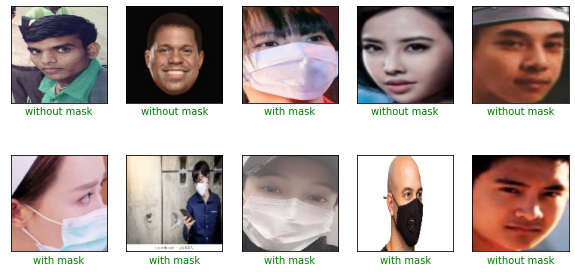

In [ ]:
(X_train,Y_train),(X_test,Y_test)=load_data()

show_some_samples(X_train,Y_train,Y_train)

# **Build Model**

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os 

In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 15
BS = 32

#Rescale test and train data
(X_train,Y_train),(X_test,Y_test)=load_data()
X_train=X_train/255
X_test=X_test/255


# construct the training image generator for data augmentation
aug = ImageDataGenerator( 
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(128, 128, 3)), input_shape=(128,128,3))

# construct the head of the model that will be placed on top of the
# the base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)

model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")

with tf.device('/device:GPU:0'):
  H = model.fit(
    aug.flow(X_train, Y_train, batch_size=BS),
    steps_per_epoch=len(X_train)//BS ,
    validation_data=(X_test, Y_test),
    validation_steps=len(X_test)//BS ,
    epochs=EPOCHS)

9412608/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...
[INFO] training head...
Epoch 1/15
100/100 [==============================] - 14s 142ms/step - loss: 0.4784 - accuracy: 0.7781 - val_loss: 0.2370 - val_accuracy: 0.9147
Epoch 2/15
100/100 [==============================] - 13s 131ms/step - loss: 0.2007 - accuracy: 0.9250 - val_loss: 0.1525 - val_accuracy: 0.9479
Epoch 3/15
100/100 [==============================] - 13s 132ms/step - loss: 0.1612 - accuracy: 0.9388 - val_loss: 0.1082 - val_accuracy: 0.9621
Epoch 4/15
100/100 [==============================] - 13s 131ms/step - loss: 0.1386 - accuracy: 0.9488 - val_loss: 0.0910 - val_accuracy: 0.9716
Epoch 5/15
100/100 [==============================] - 13s 131ms/step - loss: 0.1201 - accuracy: 0.9606 - val_loss: 0.0742 - val_accuracy: 0.9763
Epoch 6/15
100/100 [==============================] - 13s 132ms/step - loss: 0.1102 - accuracy: 0.9603 - val_loss: 0.0617 - val_accuracy: 0.9810
Epoch 7/15
100/10

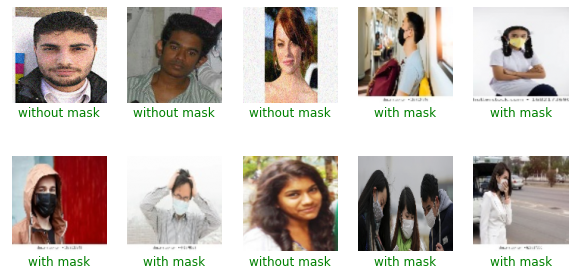

In [ ]:
preds=model.predict(X_test,batch_size=BS)

show_some_samples(X_test,Y_test,preds)

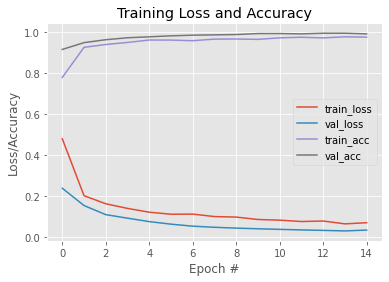

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig('plot.png')

In [ ]:
print(len(model.layers))

160


In [ ]:
model_path=PATH+"/model1"
model.save(filepath=model_path,save_format="h5")

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(X_test, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(Y_test.argmax(axis=1), predIdxs,
	target_names=class_names))

[INFO] evaluating network...
              precision    recall  f1-score   support

without mask       0.98      1.00      0.99       318
   with mask       1.00      0.98      0.99       315

    accuracy                           0.99       633
   macro avg       0.99      0.99      0.99       633
weighted avg       0.99      0.99      0.99       633



In [ ]:
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________________